In [29]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, zscore, mode
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm

SUBJECT_LIST = [2,3,4,5,6,7,8,9,10,11,13,14,15,16,17]
NUM_SUBJECTS = len(SUBJECT_LIST)

def load_dict_from_pickle(file_path):
    try:
        # Open the file in binary read mode
        with open(file_path, 'rb') as f:
            # Load the dictionary from the file
            loaded_dict = pickle.load(f)
        #print("Dictionary loaded from pickle file:", file_path)
        return loaded_dict
    except Exception as e:
        print("Error:", e)
        print("Failed to load dictionary from pickle file.")
    return None

def remove_features(feature_dict, features_to_remove):
    # Get indices of features to remove
    remove_feature_indices = np.where(np.isin(feature_dict['feature_names'], features_to_remove))
    
    # Remove them
    features = np.delete(feature_dict['features'], remove_feature_indices, axis=1)
    feature_names = np.delete(feature_dict['feature_names'], remove_feature_indices)
    
    # Create a new dict with the features removed
    new_feature_dict = {'features': features, 'feature_names': feature_names, 'labels': feature_dict['labels'], 'subject': feature_dict['subject']}
    return new_feature_dict


# Load the 3 possible feature dictionaries (different scaling)
# After some analysis of tradeoffs, I am choosing to move forward using features z-scored by subject.

# This is z-scored by subject. I'm cutting that part out of the name for simplicity. 
file_path_zscored_by_sub = f"features/combined/feature_dict_zscored_by_sub.pkl"
feature_dict = load_dict_from_pickle(file_path_zscored_by_sub)

print(feature_dict['feature_names'])

['ACC x mean' 'ACC y mean' 'ACC z mean' 'ACC mean' 'ACC x std' 'ACC y std'
 'ACC z std' 'ACC std' 'ACC abs integral x' 'ACC abs integral y'
 'ACC abs integral z' 'ACC peak frequency x' 'ACC peak frequency y'
 'ACC peak frequency z' 'EMG mean' 'EMG std' 'EMG median'
 'EMG dynamic range' 'EMG absolute integral' 'EMG 10th percentile'
 'EMG 90th percentile' 'EMG mean frequency' 'EMG peak frequency'
 'EMG # peaks' 'EMG mean peak amplitude' 'EMG std peak amplitude'
 'EMG sum peak amplitudes' 'EMG normalized sum peak amplitudes'
 'Mean inhale duration' 'Std inhale duration' 'Mean exhale duration'
 'Std exhale duration' 'Inhale/Exhale ratio' 'Respiration range'
 'Respiration rate' 'Respiration duration' 'Respiration volume'
 'Temp mean' 'Temp std' 'Temp min' 'Temp max' 'Temp dynamic range'
 'Temp slope' 'EDA mean' 'EDA std' 'EDA min' 'EDA max' 'EDA mean slope'
 'EDA dynamic range' 'SCR/SCL mean' 'SCR/SCL std' 'SCL time corr'
 'Num SCR segments' 'Sum of response durations' 'Area under SCRs'
 'H

### First, let's take a look at correlations between feature

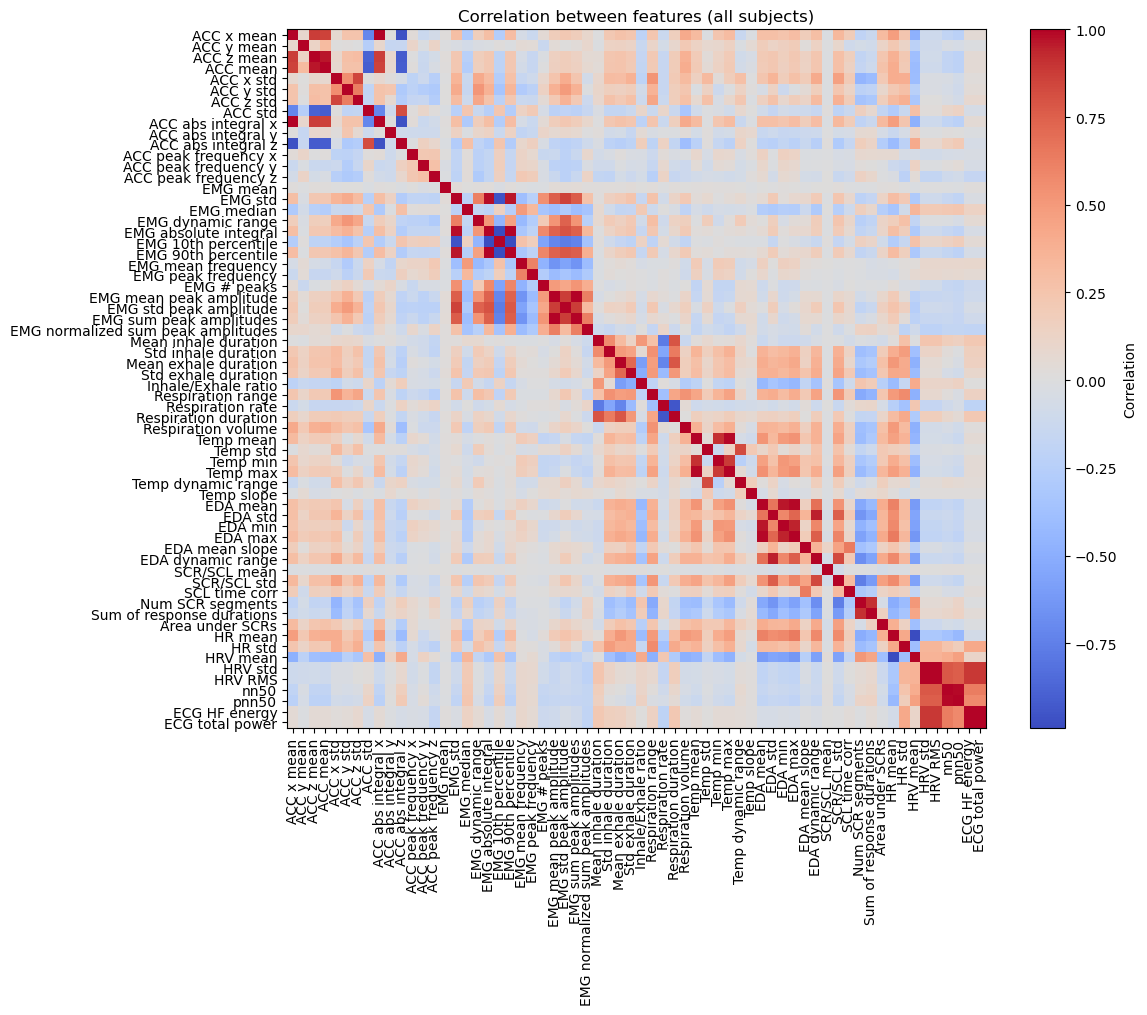

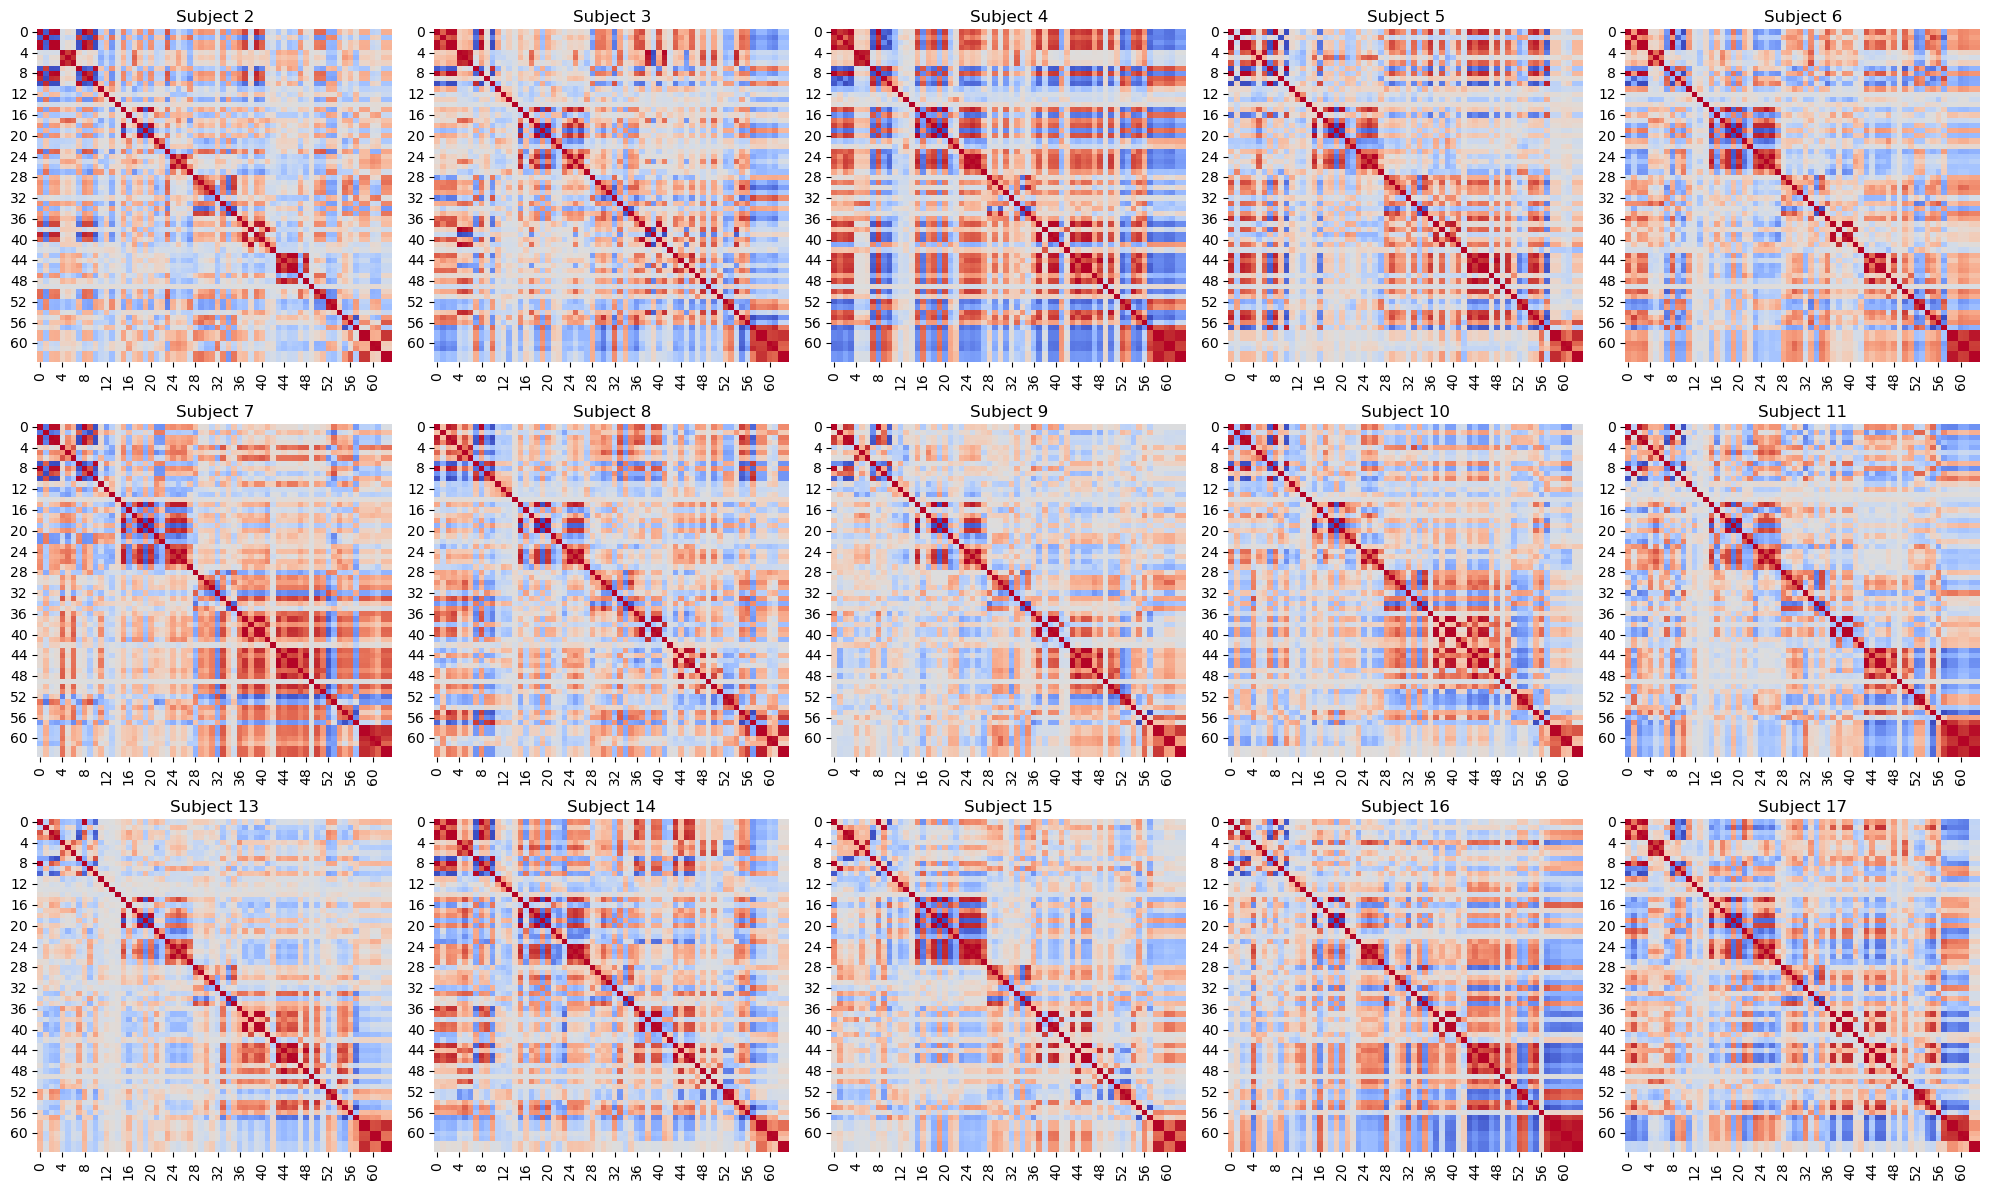

In [30]:
# Load data
file_path_zscored_by_sub = f"features/combined/feature_dict_zscored_by_sub.pkl"
feature_dict = load_dict_from_pickle(file_path_zscored_by_sub)

# Load features
feature_array = feature_dict['features']
feature_names = feature_dict['feature_names']
num_features = feature_array.shape[1]

## Plot feature correlation matrices across all subjects

# Calculate correlation matrix
corr_matrix = np.corrcoef(feature_array, rowvar=False)

# Plot heatmap
plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.title('Correlation between features (all subjects)')
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90)
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.tight_layout()
plt.show()

## Plot feature correlation matrices for each subject

# Preallocate correlation matrices
correlation_matrices = np.empty((NUM_SUBJECTS, num_features, num_features))

for i, sub in enumerate(SUBJECT_LIST):
    # Get features and calculate correlation matrices for each subject
    feats = feature_array[np.where(np.array(feature_dict['subject']) == sub)[0]]
    correlation_matrices[i] = np.corrcoef(feats, rowvar=False)

# Plot all of the correlation matrices
fig, axs = plt.subplots(3, 5, figsize=(20, 12))
for i, corr_matrix in enumerate(correlation_matrices):
    row = i // 5
    col = i % 5
    sns.heatmap(corr_matrix, ax=axs[row, col], cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
    axs[row, col].set_title(f'Subject {SUBJECT_LIST[i]}')

plt.tight_layout()
plt.show()

In [40]:
# Load data
file_path_zscored_by_sub = f"features/combined/feature_dict_zscored_by_sub.pkl"
feature_dict = load_dict_from_pickle(file_path_zscored_by_sub)

# Load features
reduced_feature_dict_1 = remove_features(feature_dict, features_to_remove_1)
num_features = feature_array.shape[1]
print(len(reduced_feature_dict_1['feature_names']))

28


### Remove some features based on correlations and domain knowledge and do it again

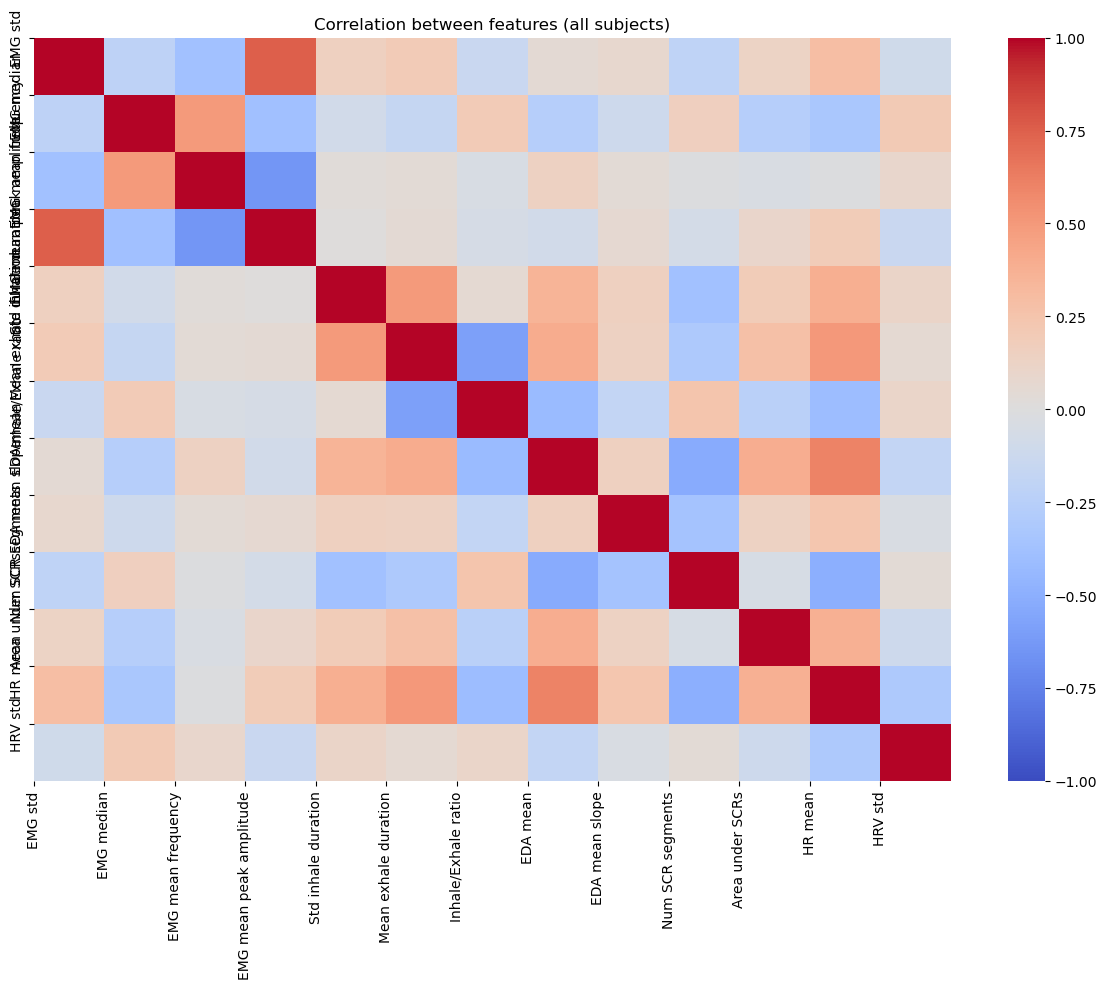

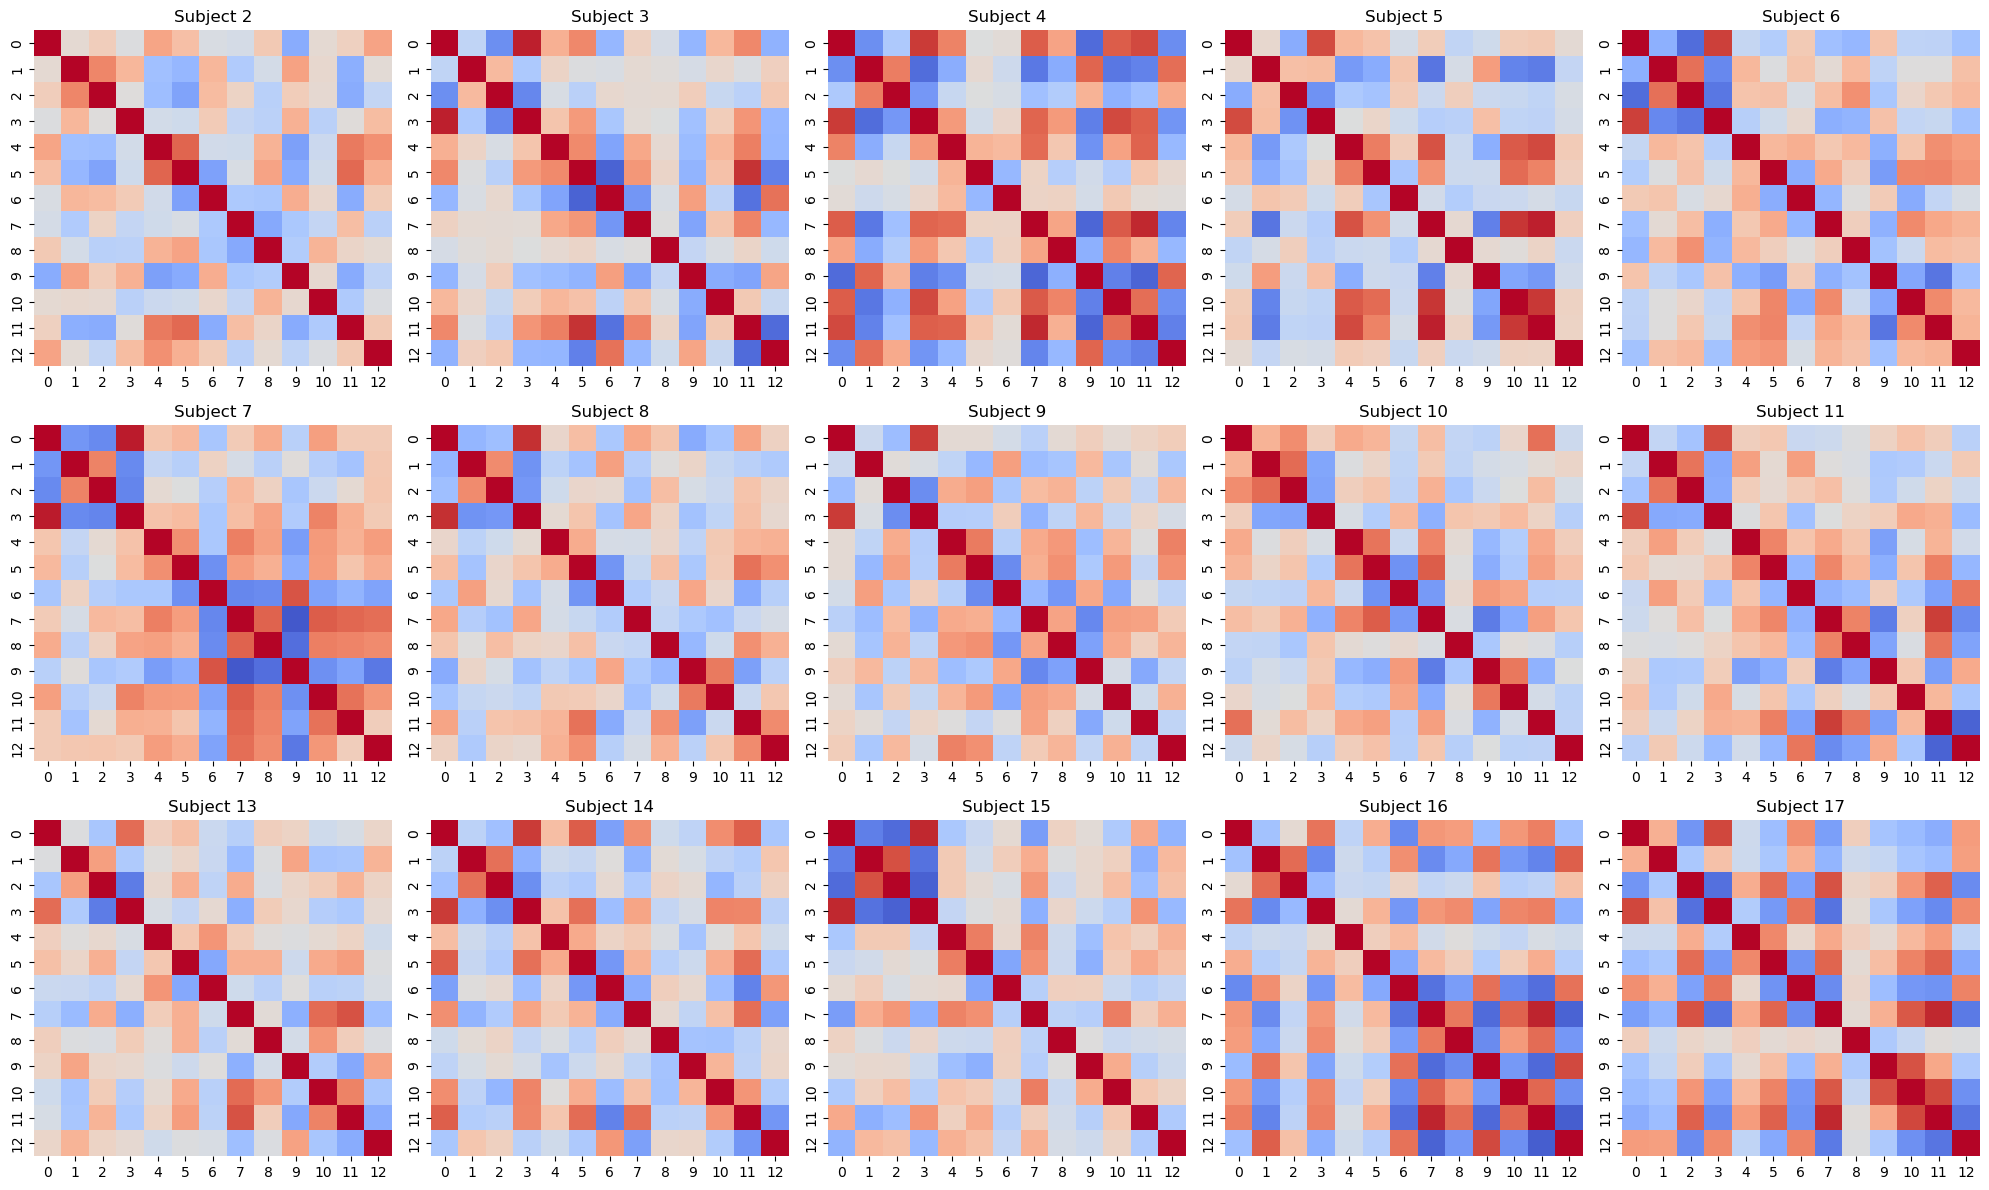

In [28]:
# Features to remove in the first pass based on domain knowledge and correlations.
features_to_remove_1 = ['ACC x mean', 'ACC y mean', 'ACC z mean', 'ACC mean', 'ACC x std', 'ACC y std',
                    'ACC z std', 'ACC std', 'ACC abs integral x', 'ACC abs integral y', 'ACC abs integral z',
                    'ACC peak frequency x', 'ACC peak frequency y', 'ACC peak frequency z', 
                    'EMG dynamic range', 'EMG absolute integral','EMG 10th percentile', 'EMG 90th percentile','EMG peak frequency', 'EMG std peak amplitude', 
                    'EMG sum peak amplitudes', 'EMG normalized sum peak amplitudes', 'Respiration duration',
                    'Temp min', 'Temp max', 'Temp dynamic range', 'EDA std', 'EDA min', 'EDA max', 'EDA dynamic range', 
                    'Sum of response durations', 'HRV mean', 'HRV RMS', 'nn50', 'pnn50', 'ECG HF energy']

# Features to remove in the second pass based on importance. Remove all temp, not biologically relevant enough
features_to_remove_2 = ['EMG mean', 'EMG # peaks', 'Mean inhale duration', 'Std exhale duration', 'Respiration range',
                       'Respiration rate', 'Respiration volume', 'Temp mean', 'Temp std', 'Temp slope', 'SCR/SCL mean',
                       'SCR/SCL std', 'SCL time corr', 'HR std', 'ECG total power']
# Remove features
reduced_feature_dict_1 = remove_features(feature_dict, features_to_remove_1)
reduced_feature_dict_2 = remove_features(reduced_feature_dict_1, features_to_remove_2)

# Load features
feature_array = reduced_feature_dict_1['features']
feature_names = reduced_feature_dict_1['feature_names']
num_features = feature_array.shape[1]


## Plot feature correlation matrices across all subjects

# Calculate correlation matrix
corr_matrix = np.corrcoef(feature_array, rowvar=False)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
#plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
#plt.colorbar(label='Correlation')
plt.title('Correlation between features (all subjects)')
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90)
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.tight_layout()
plt.show()


## Plot feature correlation matrices for each subject

# Preallocate correlation matrices
correlation_matrices = np.empty((NUM_SUBJECTS, num_features, num_features))

for i, sub in enumerate(SUBJECT_LIST):
    # Get features and calculate correlation matrices for each subject
    feats = feature_array[np.where(np.array(feature_dict['subject']) == sub)[0]]
    correlation_matrices[i] = np.corrcoef(feats, rowvar=False)

# Plot all of the correlation matrices
fig, axs = plt.subplots(3, 5, figsize=(20, 12))
for i, corr_matrix in enumerate(correlation_matrices):
    row = i // 5
    col = i % 5
    sns.heatmap(corr_matrix, ax=axs[row, col], cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
    axs[row, col].set_title(f'Subject {SUBJECT_LIST[i]}')

plt.tight_layout()
plt.show()

In [31]:
def train_test_split_LOOCV(feature_dict, test_subject):
    '''
    Given the feature dict containing features for all of the subjects, 
    and the subject to leave out (test_subject), splits the data 
    into train and test data for Leave One Out Cross-Validation (LOOCV).
    
    Returns:
    X_train, X_test, y_train, y_test (train data, test data, train labels, test labels)
    '''
    
    features = feature_dict['features']
    labels = feature_dict['labels']
    train_indices = np.where(np.array(feature_dict['subject']) != test_subject)[0]
    test_indices = np.where(np.array(feature_dict['subject']) == test_subject)[0]
    
    # Yell at is if there is any overlap, just in case
    if np.any(np.isin(train_indices, test_indices)):
        print("NO! Train and test overlap!!!!!!")
        
    return features[train_indices], features[test_indices], labels[train_indices], labels[test_indices]


def train_test_split_LOOCV_binary(feature_dict, test_subject):
    '''
    Given the feature dict containing features for all of the subjects, 
    and the subject to leave out (test_subject), splits the data 
    into train and test data for Leave One Out Cross-Validation (LOOCV).
    
    Remove the amusement condition (no labels == 3) to make this a binary classification problem.
    
    Returns:
    X_train, X_test, y_train, y_test (train data, test data, train labels, test labels)
    '''
    
    features = feature_dict['features']
    labels = feature_dict['labels']

    train_indices = np.where((np.array(feature_dict['subject']) != test_subject) & (labels != 3))[0]
    test_indices = np.where((np.array(feature_dict['subject']) == test_subject) & (labels != 3))[0]
    
    # Yell at is if there is any overlap, just in case
    if np.any(np.isin(train_indices, test_indices)):
        print("NO! Train and test overlap!!!!!!")
        
    return features[train_indices], features[test_indices], labels[train_indices], labels[test_indices]

### Confirm that removing features didn't ruin our accuracy (LDA)

Also, take a look at the LDA model coefficients

[[66088.   756.]
 [  896. 35368.]]
Accuracy =  0.9834178588149789  Std:  0.03619307901706505
F1 =  0.9870412549053768  Std:  0.02888500043094737
Coefs =  [-1.55060986e-01  1.32841890e+00 -1.30017967e+00  1.28372944e+00
 -2.21597554e-01 -1.65334045e+00  3.19170863e-01  2.83728871e+00
  1.03486541e+00 -9.47083811e-01 -3.24681205e+00 -4.54310726e-01
  1.23946002e-01  2.84513764e-01  4.23910805e+00 -5.15397654e-01
  2.01518591e-01  4.47265329e+00  1.54642609e+00 -2.65291275e-01
  2.44652710e-03 -6.76784903e-01 -1.91936740e+00  2.00368254e+00
  6.78807371e+00 -5.28021658e-01  2.41046854e+00 -1.09622485e+00]
Std coefs =  [0.03124847 0.36022176 0.12786735 0.34845336 0.34212354 0.5986166
 0.48597838 0.2313215  0.31787125 0.1700364  0.46965473 0.15597364
 0.18180191 0.23564068 0.2480087  0.14253558 0.10703623 0.93474848
 0.17035292 0.03119889 0.34580383 0.12696314 0.23404752 0.22211467
 0.60386342 0.16513714 0.47568684 0.41982742]


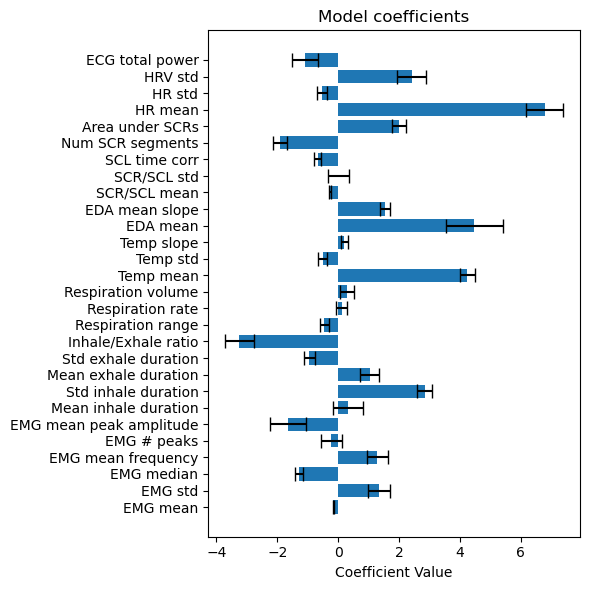

In [45]:
##### Train 15 LDA models, leaving one subject out each time

# Load data
file_path_zscored_by_sub = f"features/combined/feature_dict_zscored_by_sub.pkl"
feature_dict = load_dict_from_pickle(file_path_zscored_by_sub)
# Remove features
feature_dict = remove_features(feature_dict, features_to_remove_1)
#feature_dict = remove_features(feature_dict, features_to_remove_2)

num_features = len(feature_dict['feature_names'])
accuracies = np.zeros(len(SUBJECT_LIST))
f1_scores = np.zeros(len(SUBJECT_LIST))
coefs = np.zeros((len(SUBJECT_LIST), num_features))
confusion_matrices = np.zeros((len(SUBJECT_LIST), 2, 2)) 

for i, test_sub in enumerate(SUBJECT_LIST):
    
    # Split the data into training and testing sets by subject
    X_train, X_test, y_train, y_test = train_test_split_LOOCV_binary(feature_dict, test_sub)
    
    # Fit the model
    model = LinearDiscriminantAnalysis() # could also be QuadraticDiscriminantAnalysis(), but this actually performs worse
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracies[i] = accuracy_score(y_test, y_pred)
    f1_scores[i] = f1_score(y_test, y_pred)
    coefs[i] = model.coef_
    confusion_matrices[i] = confusion_matrix(y_test, y_pred)

combined_confusion_matrix = np.sum(confusion_matrices, axis=0)
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
mean_coefs = np.mean(coefs, axis=0)
std_coefs = np.std(coefs, axis=0)

print(combined_confusion_matrix)
print("Accuracy = ", mean_acc, " Std: ", std_acc)
print("F1 = ", mean_f1, " Std: ", std_f1)
print("Coefs = ", mean_coefs)
print("Std coefs = ", std_coefs)

# Bar graph of coef magnitudes
x = np.arange(num_features)
plt.figure(figsize=(6, 6))
plt.barh(x, mean_coefs, xerr=std_coefs, capsize=5)
#plt.xlabel('Feature Index')
plt.xlabel('Coefficient Value')
plt.title('Model coefficients')
plt.yticks(x, feature_dict['feature_names'])
plt.tight_layout() 
plt.show()

### Confirm that removing features didn't ruin our accuracy (MLP)

In [38]:
# Load data
file_path_zscored_by_sub = f"features/combined/feature_dict_zscored_by_sub.pkl"
feature_dict = load_dict_from_pickle(file_path_zscored_by_sub)
# Remove features
feature_dict = remove_features(feature_dict, features_to_remove_1)
#feature_dict = remove_features(feature_dict, features_to_remove_2)

num_features = len(feature_dict['feature_names'])
accuracies = np.zeros(len(SUBJECT_LIST))
f1_scores = np.zeros(len(SUBJECT_LIST))
confusion_matrices = np.zeros((len(SUBJECT_LIST), 2, 2)) 

for i, test_sub in tqdm(enumerate(SUBJECT_LIST)):
    # Split the data into training and testing sets by subject
    X_train, X_test, y_train, y_test = train_test_split_LOOCV_binary(feature_dict, test_sub)
    
    # Create a simple neural net
    model = MLPClassifier(hidden_layer_sizes=(32,), activation='relu', solver='adam', random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracies[i] = accuracy_score(y_test, y_pred)
    f1_scores[i] = f1_score(y_test, y_pred)
    confusion_matrices[i] = confusion_matrix(y_test, y_pred)

combined_confusion_matrix = np.sum(confusion_matrices, axis=0)
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(combined_confusion_matrix)
print("Accuracy = ", mean_acc, " Std: ", std_acc)
print("F1 = ", mean_f1, " Std: ", std_f1)

15it [00:26,  1.79s/it]

[[65689.  1155.]
 [ 1356. 34908.]]
Accuracy =  0.9750435648969326  Std:  0.042763613608345935
F1 =  0.9807126953926615  Std:  0.03349995721577352


Also, take a look at regularization and SHAP values

Training ... 


  0%|          | 0/500 [00:00<?, ?it/s]

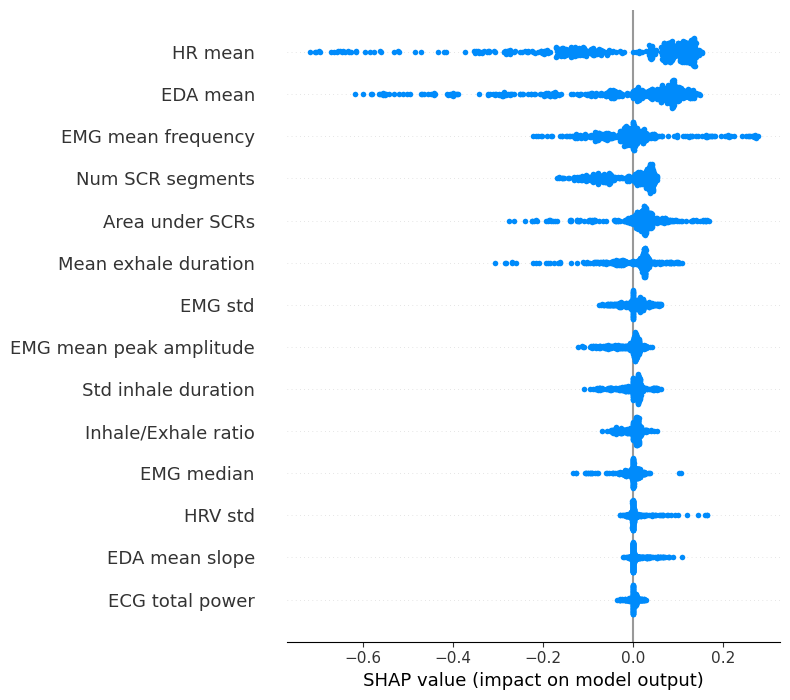

100%|███████████████████████████████████████████| 10/10 [00:30<00:00,  3.02s/it]


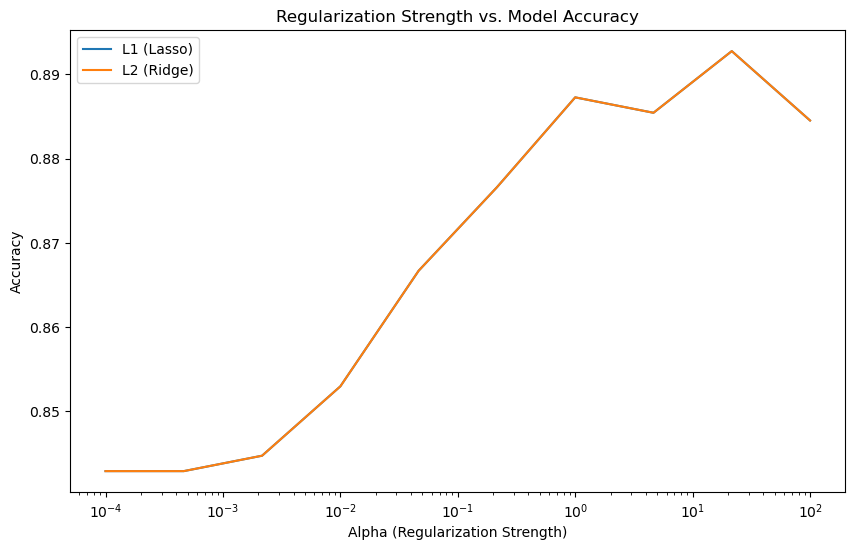

In [12]:
import numpy as np
import shap
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

test_sub = 2
feature_names = feature_dict['feature_names']

# Split the data into training and testing sets by subject
X_train, X_test, y_train, y_test = train_test_split_LOOCV_binary(feature_dict, test_sub)

# Create a simple multi-layer perceptron classifier
model = MLPClassifier(hidden_layer_sizes=(32,), activation='relu', solver='adam', random_state=42)

# Train the model
print("Training ... ")
model.fit(X_train, y_train)

# Set up for SHAP values
background = shap.sample(X_train, 100)  # Use 100 background samples
explainer = shap.KernelExplainer(model.predict_proba, background)

# Calculate SHAP values - randomly select 500 samples from X_test (it's too slow to use the whole thing)
random_samples = np.random.randint(0, X_test.shape[0], size=500)
shap_values = explainer.shap_values(X_test[random_samples, :])

# Plot SHAP summary plot
shap.summary_plot(shap_values[:,:,0], feature_names=feature_names, max_display=len(feature_names))

# Investigate regularization with different alphas
alphas = np.logspace(-4, 2, 10)
reg_scores = []
for alpha in tqdm(alphas):
    model_reg = MLPClassifier(hidden_layer_sizes=(32,), activation='relu', solver='adam', alpha=alpha, random_state=42)
    model_reg.fit(X_train, y_train)
    reg_scores.append(model_reg.score(X_test, y_test))

# Plot regularization strength vs. accuracy
plt.figure(figsize=(10, 6))
plt.plot(alphas, reg_scores)
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Regularization Strength vs. Model Accuracy')
plt.legend()
plt.show()